In [2]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az

In [3]:
#### Preprocecing ###

In [4]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [5]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [6]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]
confirmed = confirmed.cummax()

In [7]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]
recovered = recovered.cummax()


In [8]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]
death = death.cummax()

In [9]:
### Data Preparation ###

In [20]:
country = 'Japan'
C0 = confirmed[country].values
R0 = (recovered)[country].values
D0 = death[country].values
P = 12000_0000
iter=100000
repeat = 1000
epoch = pd.to_datetime('2020-01-22')

In [21]:
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [12]:
### Model ###

In [27]:
sm_q0 = pystan.StanModel(file="turzin-start-q0.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_054b2e1c4d4a291c5a6d0677d680da52 NOW.


In [24]:
sm_0 = pystan.StanModel(file="turzin-start-0.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b6525409ccd2ffd2d935a675ddd7f096 NOW.


In [28]:
# Train the model and generate samples
fit_start_q0 = sm_q0.sampling(data=data, iter=iter, init=0)
fit_start_q0

Inference for Stan model: anon_model_054b2e1c4d4a291c5a6d0677d680da52.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   7.97  4.3e-3   1.46   5.53   6.94   7.83   8.84  11.26 115908    1.0
b0         0.11  9.8e-6 3.5e-3    0.1    0.1   0.11   0.11   0.11 128751    1.0
b1         0.14  5.4e-6 2.2e-3   0.14   0.14   0.14   0.14   0.14 167934    1.0
theta_b    1.25  1.5e-3   0.62   0.45    0.8   1.11   1.54   2.78 178545    1.0
b_date    58.25  3.4e-3   1.31  55.43   57.5   58.3  59.07  60.68 147849    1.0
q0          0.9  2.6e-4   0.08   0.69   0.86   0.93   0.97    1.0 100623    1.0
q1         0.28  1.1e-4   0.03    0.2   0.25   0.28    0.3   0.34 100476    1.0
theta_q     4.2  2.3e-3   1.02   2.45   3.48   4.11   4.82   6.46 191776    1.0
q_date    54.19  3.2e-4   0.13  53.93  54.11  54.19  54.28  54.45 169918    1.0
a    

In [26]:
# Train the model and generate samples
fit_start_0 = sm_0.sampling(data=data, iter=iter, init=0)
fit_start_0

Inference for Stan model: anon_model_b6525409ccd2ffd2d935a675ddd7f096.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  22.65    0.01   3.31  16.89  20.31  22.42  24.74  29.76  59223    1.0
b0         0.08  9.6e-6 2.2e-3   0.08   0.08   0.08   0.08   0.08  53645    1.0
b1         0.13  4.6e-6 1.8e-3   0.12   0.12   0.13   0.13   0.13 156066    1.0
theta_b    4.27  2.3e-3   0.98   2.67   3.57   4.16   4.85   6.52 185297    1.0
b_date     70.6  3.3e-4   0.14  70.34  70.51   70.6   70.7  70.87 176811    1.0
q1         0.92  1.3e-4   0.05    0.8   0.89   0.93   0.96   0.99 167653    1.0
theta_q    0.24  1.7e-3   0.29    0.1   0.13   0.16    0.2   1.14  28850    1.0
q_date     8.99    0.02   3.87   1.56   5.99    9.1  11.92  16.05  41340    1.0
a          0.01  1.3e-6 4.4e-4   0.01   0.01   0.01   0.01   0.01 114987    1.0
d    

In [39]:
fit = fit_start_q0

In [40]:
### Visualization functions ###

In [41]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-theta*(x-t0)))

In [42]:
def simulate(init_inf, b0, b1, theta_b, b_date, q0, q1, theta_q, q_date,
             a, d, horizon):
    S = init_inf;
    R = 0;
    D = 0;
    S_list = [S]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q_list = [0]
    S0 = [0]
    R0 = [0]
    D0 = [D]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date)
        I = (S - R - D) * b * (1 - S/P)
        q = q0 + (q1 - q0) * sigmoid(t, theta_q, q_date)
        NR = a * (S - R - D)
        ND = d * (S - R - D)
        D = D + ND
        S = S + I
        R = R + NR
        S_list.append(S)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        S0.append(S0[-1]+q*I)
        R0.append(R0[-1]+a * (S0[-1] - R0[-1] - D0[-1]))
    data = pd.DataFrame({'S':np.array(S_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'S0':np.array(S0),
                        'R0':np.array(R0)},
                        index=pd.date_range(start=epoch, periods=horizon+1, freq='D'))
    return data

In [43]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    n = fit['init_inf'].shape[0]
    for k in range(repeat):
        i = np.random.randint(n)
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=fit['q0'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      horizon=horizon)
        S = pd.concat([S, df['S']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        S0 = pd.concat([S0, df['S0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        I0 = pd.concat([I0, df['S0'] - df['R0']], axis=1)
    return S, R, D, b, q, S0, R0, I0
    

In [44]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [45]:
def draw(simulated, real=None, upto=pd.to_datetime('today')):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [46]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit, 120)

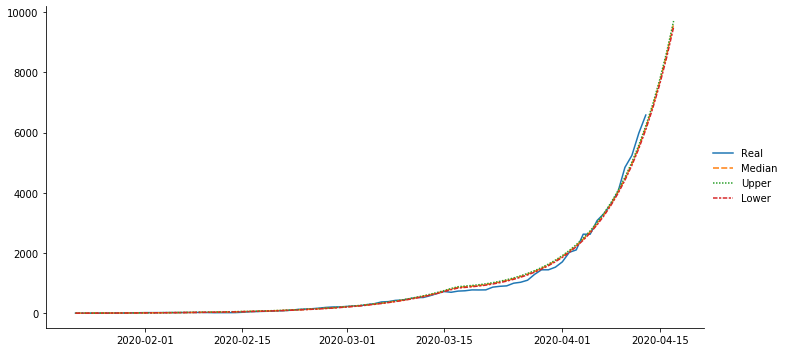

In [47]:
draw(I0, real=(confirmed-recovered)[country])

In [48]:
S.median(axis=1)[pd.to_datetime('2020-04-15')]

29299.57308910072

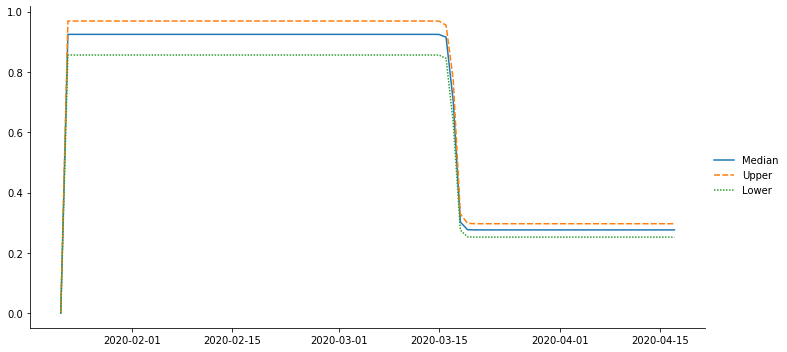

In [49]:
draw(q)

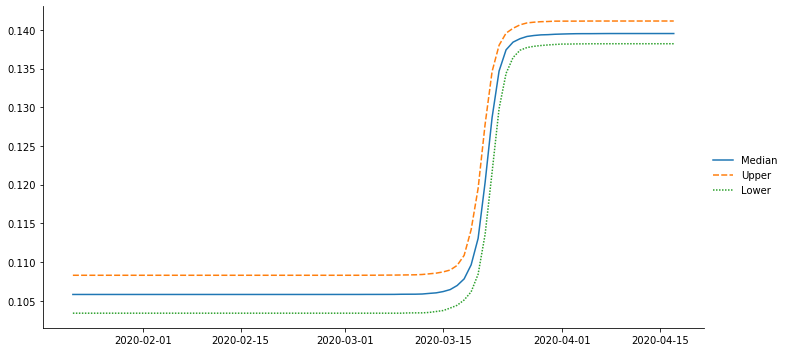

In [50]:
draw(b)

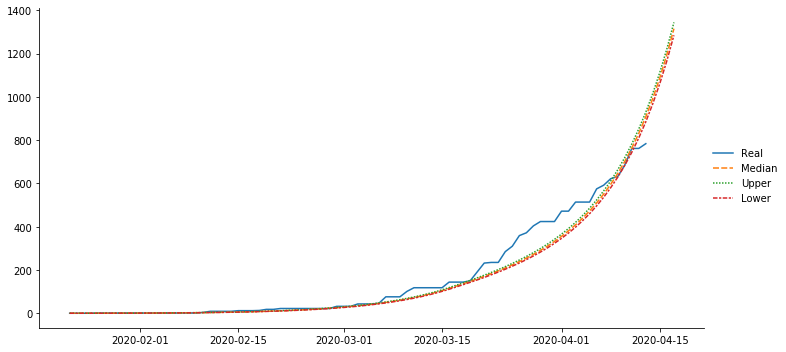

In [51]:
draw(R0, real=recovered[country])

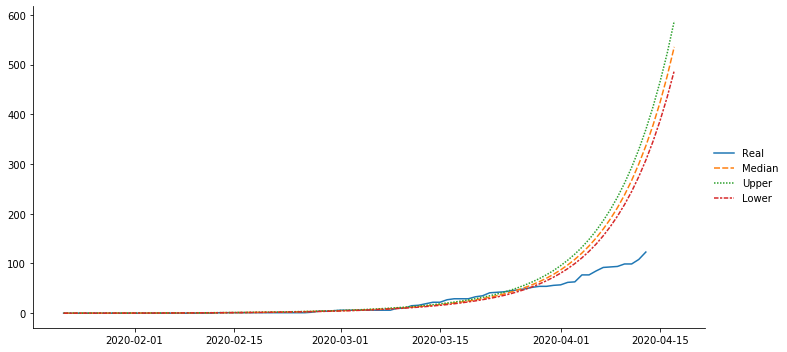

In [52]:
draw(D, real=death[country])

In [53]:
cumulative = pd.DataFrame(S.values, columns=range(len(S.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

In [54]:
predicted_recovered = pd.DataFrame(R.values, columns=range(len(R.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

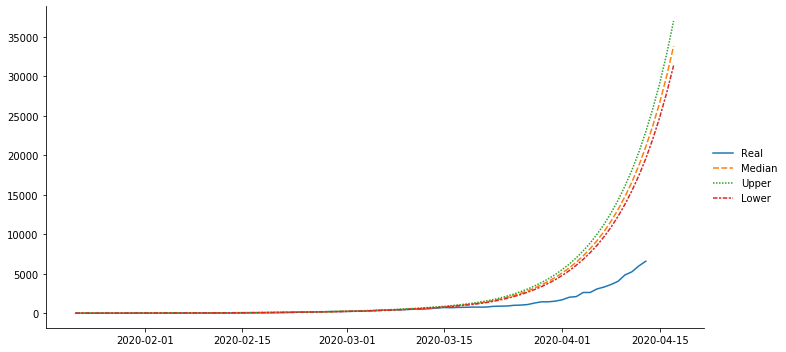

In [55]:
draw(cumulative - predicted_recovered, real=(confirmed-recovered)[country])

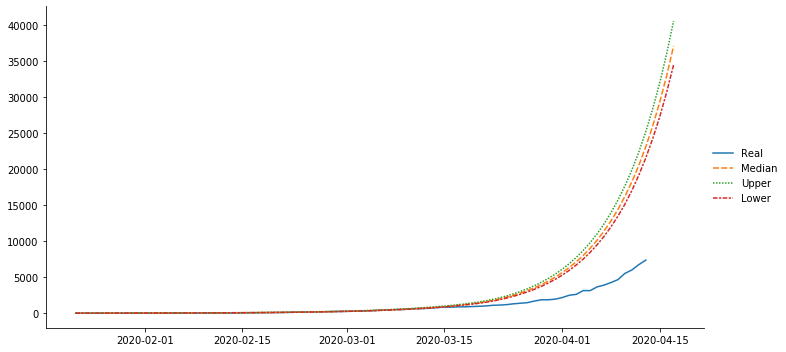

In [56]:
draw(cumulative, real=confirmed[country])

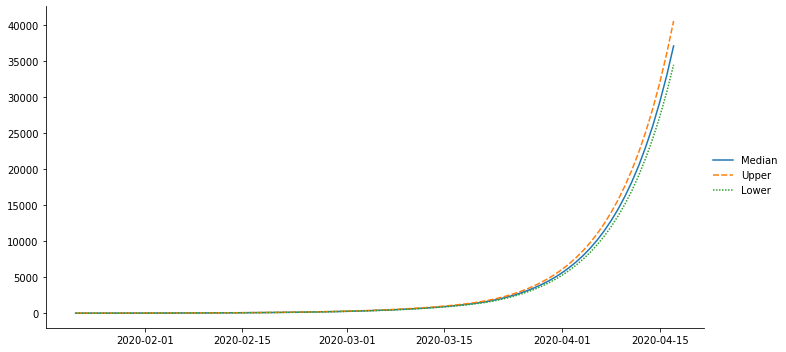

In [57]:
draw(S)

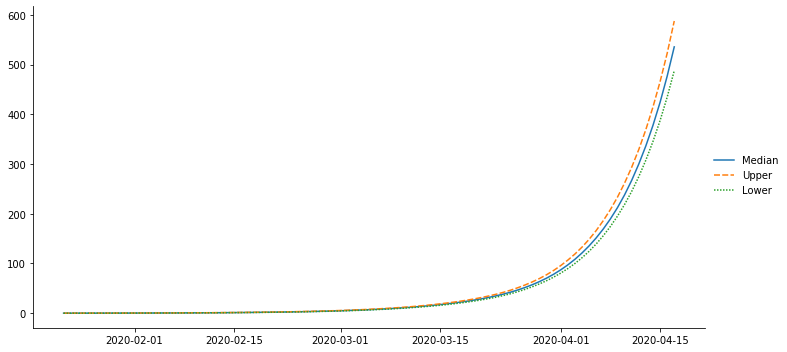

In [58]:
draw(D)

In [ ]:
country = 'Korea, South'
C0 = confirmed[country].values
R0 = (recovered)[country].values
D0 = death[country].values
P = 5170_0000
iter=100000
repeat = 1000
epoch = pd.to_datetime('2020-01-22')
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [ ]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter, init=0)

In [ ]:
fit

In [ ]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit, 120)

In [ ]:
draw(I0, real=(confirmed-recovered)[country])

In [ ]:
draw(R0, real=recovered[country])

In [ ]:
draw(D, real=death[country])

In [ ]:
draw(q)

In [ ]:
draw(b)

In [ ]:
country = 'Italy'
epoch = pd.to_datetime('2020-02-01')
C0 = confirmed.loc[epoch:, country].values
R0 = (recovered).loc[epoch:, country].values
D0 = death.loc[epoch:, country].values
P = 6000_0000
iter=100000
repeat = 1000
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
fit = sm.sampling(data=data, iter=iter, init=0)
fit

In [ ]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit, 120)


In [ ]:
draw(I0, real=(confirmed-recovered).loc[epoch:, country])
draw(q)
draw(b)

In [ ]:
draw(S, real=(confirmed).loc[epoch:, country])

In [ ]:
country = 'Israel'
epoch = pd.to_datetime('2020-02-21')
C0 = confirmed.loc[epoch:, country].values
R0 = (recovered).loc[epoch:, country].values
D0 = death.loc[epoch:, country].values
P = 6000_0000
iter=100000
repeat = 1000
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
fit = sm.sampling(data=data, iter=iter, init=0)
fit

In [ ]:
confirmed.loc[pd.to_datetime('2020-01-22'):, 'US'].values

In [ ]:
country = 'US'
epoch = pd.to_datetime('2020-01-22')
C0 = confirmed.loc[epoch:, country].values
R0 = (recovered).loc[epoch:, country].values
D0 = death.loc[epoch:, country].values
P = 328_200_000
iter=100000
repeat = 1000
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
fit = sm.sampling(data=data, iter=iter, init=0)
fit

In [ ]:
draw(I0, real=(confirmed-recovered).loc[epoch:, country])
draw(q)
draw(b)